/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


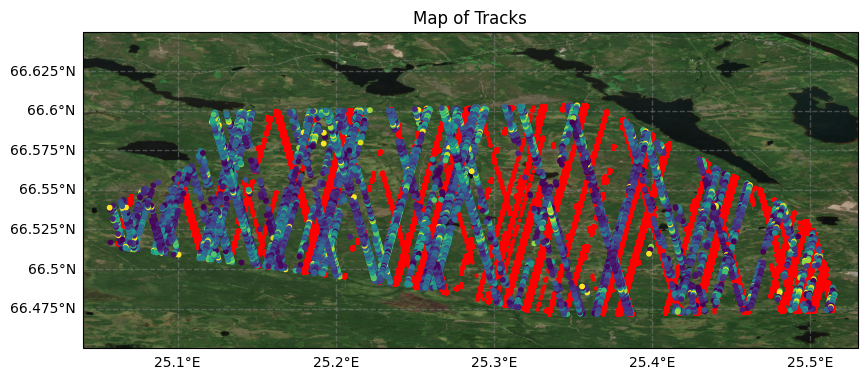

In [1]:
from scripts.track_pairs import *
from scripts.show_tracks import *

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed = True)

# extent = [25.2, 25.4, 66.45, 66.65]
fig, ax = map_setup(map_path = dirpath + '/rovaniemi_image.tiff', extent = (25.04,25.53,66.45,66.65))

for i in range(len(failed_ATL03)):
    ax = show_tracks_only_atl03(failed_ATL03[i], ax)
for i in range(len(all_ATL03)):
    ax = show_tracks(all_ATL03[i], all_ATL08[i], ax, c='Ev', CBAR = None)

# Show the plot
plt.show()

In [3]:
#failed_ATL03

Focus on ATL08_20210527155150_09751103_006_01.h5

/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


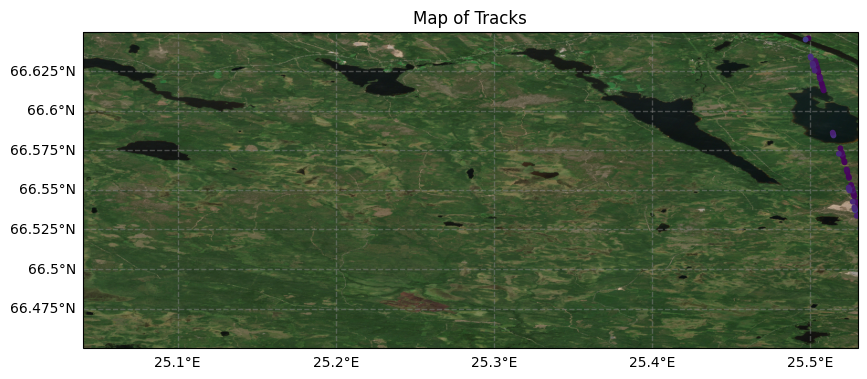

In [1]:
from scripts.track_pairs import *
from scripts.show_tracks import *

dirpath = '../data/rovaniemi_w_failed/'
all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed = True)

from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
                        
class ATL03_without_ATL08:
    def __init__(self, atl03Path, gtx):
        self.fpath = atl03Path
        self.gtx = gtx
        self.load()
    
    def load(self,):
        # Read ATL03 segment data
        f = h5py.File(self.fpath, 'r')
        atl03_lat = np.array(f[self.gtx + '/heights/lat_ph'][:])
        atl03_lon = np.array(f[self.gtx + '/heights/lon_ph'][:])
        atl03_ph_index_beg  = np.array(f[self.gtx + '/geolocation/ph_index_beg'][:])
        atl03_segment_id = np.array(f[self.gtx + '/geolocation/segment_id'][:])
        atl03_heights = np.array(f[self.gtx + '/heights/h_ph'][:])
        atl03_conf =  np.array(f[self.gtx + '/heights/signal_conf_ph'][:])
        
        # Get ATL03 data
        indsNotZero = atl03_ph_index_beg != 0
        atl03_ph_index_beg = atl03_ph_index_beg[indsNotZero];
        atl03_segment_id = atl03_segment_id[indsNotZero];
            
        self.df = pd.DataFrame()
        self.df['lon'] = atl03_lon # longitude
        self.df['lat'] = atl03_lat # latitude
        self.df['z'] = atl03_heights # elevation
        self.df['conf'] = atl03_conf[:,0] # confidence flag

    def ismember(self, a_vec, b_vec, method_type = 'normal'):    
        """ MATLAB equivalent ismember function """
        # Combine multi column arrays into a 1-D array of strings if necessary
        # This will ensure unique rows when using np.isin below
        if(method_type.lower() == 'rows'):

            # Turn a_vec into an array of strings
            a_str = a_vec.astype('str')
            b_str = b_vec.astype('str')

            # Concatenate each column of strings with commas into a 1-D array of strings
            for i in range(0,np.shape(a_str)[1]):
                a_char = np.char.array(a_str[:,i])
                b_char = np.char.array(b_str[:,i])
                if(i==0):
                    a_vec = a_char
                    b_vec = b_char
                else:
                    a_vec = a_vec + ',' + a_char
                    b_vec = b_vec + ',' + b_char

        matchingTF = np.isin(a_vec,b_vec)
        common = a_vec[matchingTF]
        common_unique, common_inv  = np.unique(common, return_inverse=True)     # common = common_unique[common_inv]
        b_unique, b_ind = np.unique(b_vec, return_index=True)  # b_unique = b_vec[b_ind]
        common_ind = b_ind[np.isin(b_unique, common_unique, assume_unique=True)]
        matchingInds = common_ind[common_inv]

        return matchingTF, matchingInds

class ATL03:
    def __init__(self, atl03Path, atl08Path, gtx, LAT, LON):
        self.fpath = atl03Path
        self.gtx = gtx
        self.load(atl08Path)
        self.class_dict = {-1: {'color':cmap(0.98),
                                'name':'Unclassified'},
                           0: {'color':cmap(0.2),
                               'name':'Noise'},
                           1: {'color':cmap(0.8),
                               'name':'Ground'},
                           2: {'color':cmap(0.4),
                               'name':'Canopy'},
                           3: {'color':cmap(0.6),
                               'name':'Top of canopy'}}
        
    def plot(self, ax, gt):
        for c in np.unique(self.df.classification):
            mask = self.df.classification==c
            ax.scatter(self.df[mask].lat,
                       self.df[mask].z,
                       color=self.class_dict[c]['color'],
                       label=self.class_dict[c]['name'],s=2)
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Elevation (m)')
        ax.set_title(gt)
        # ax.legend(loc='best')
        
    def plot_small(self, ax, gt):
        for c in np.unique(self.df.classification):
            mask = self.df.classification==c
            ax.scatter(self.df[mask].lat,
                       self.df[mask].z,
                       color=self.class_dict[c]['color'],
                       label=self.class_dict[c]['name'],s=2)
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Elevation (m)')
        ax.set_title(gt)
        # ax.legend(loc='best')
        
        # Set specific ticks for both x and y axes
        x_ticks = np.linspace(self.df.lat.min(), self.df.lat.max(), 3)
        y_ticks = np.linspace(self.df.z.min(), self.df.z.max(), 3)

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
    
    def load(self, atl08Path):
        # Read ATL03 segment data
        f = h5py.File(self.fpath, 'r')
        atl03_lat = np.array(f[self.gtx + '/heights/lat_ph'][:])
        atl03_lon = np.array(f[self.gtx + '/heights/lon_ph'][:])
        atl03_ph_index_beg  = np.array(f[self.gtx + '/geolocation/ph_index_beg'][:])
        atl03_segment_id = np.array(f[self.gtx + '/geolocation/segment_id'][:])
        atl03_heights = np.array(f[self.gtx + '/heights/h_ph'][:])
        atl03_conf =  np.array(f[self.gtx + '/heights/signal_conf_ph'][:])
        
        # Read ATL08 classifications
        f = h5py.File(atl08Path, 'r')
        atl08_classed_pc_indx = np.array(f[self.gtx + '/signal_photons/classed_pc_indx'][:])
        atl08_classed_pc_flag = np.array(f[self.gtx + '/signal_photons/classed_pc_flag'][:])
        atl08_segment_id = np.array(f[self.gtx + '/signal_photons/ph_segment_id'][:])
        atl08_ph_h = np.array(f[self.gtx + '/signal_photons/ph_h'][:])
        f.close()
        
        # Get ATL03 data
        indsNotZero = atl03_ph_index_beg != 0
        atl03_ph_index_beg = atl03_ph_index_beg[indsNotZero];
        atl03_segment_id = atl03_segment_id[indsNotZero];
        
        # Find ATL08 segments that have ATL03 segments
        atl03SegsIn08TF, atl03SegsIn08Inds = self.ismember(atl08_segment_id, atl03_segment_id)

        # Get ATL08 classed indices and values
        atl08classed_inds = atl08_classed_pc_indx[atl03SegsIn08TF]
        atl08classed_vals = atl08_classed_pc_flag[atl03SegsIn08TF]
        atl08_hrel = atl08_ph_h[atl03SegsIn08TF]

        # Determine new mapping into ATL03 data
        atl03_ph_beg_inds = atl03SegsIn08Inds;
        atl03_ph_beg_val = atl03_ph_index_beg[atl03_ph_beg_inds]
        newMapping = atl08classed_inds + atl03_ph_beg_val - 2

        # Get max size of output array
        sizeOutput = newMapping[-1]

        # Pre-populate all photon classed array with zeroes
        allph_classed = (np.zeros(sizeOutput + 1)) - 1
        allph_hrel = np.full(sizeOutput + 1, np.nan)

        # Populate all photon classed array from ATL08 classifications
        allph_classed[newMapping] = atl08classed_vals
        allph_hrel[newMapping] = atl08_hrel

        # Return all photon classed array
        if len(allph_classed) < len(atl03_heights):
            n_zeros = len(atl03_heights) - len(allph_classed)
            zeros = np.zeros(n_zeros)
            allph_classed = np.append(allph_classed, zeros)
        
        if len(allph_hrel) < len(atl03_heights):
            n_zeros = len(atl03_heights) - len(allph_hrel)
            zeros = np.full(n_zeros, np.nan)
            allph_hrel = np.append(allph_hrel, zeros)
            
        if len(allph_hrel) > len(atl03_heights):
            n_zeros = len(allph_hrel) - len(atl03_heights)
            allph_hrel = allph_hrel[:-n_zeros]

        if len(allph_classed) > len(atl03_heights):
            n_zeros = len(allph_classed) - len(atl03_heights)
            allph_classed = allph_classed[:-n_zeros]
            
        self.df = pd.DataFrame()
        self.df['lon'] = atl03_lon # longitude
        self.df['lat'] = atl03_lat # latitude
        self.df['z'] = atl03_heights # elevation
        self.df['h'] = allph_hrel # height relative to local atl08 ground 
        self.df['conf'] = atl03_conf[:,0] # confidence flag
        self.df['classification'] = allph_classed # atl08 classification

    def ismember(self, a_vec, b_vec, method_type = 'normal'):    
        """ MATLAB equivalent ismember function """
        # Combine multi column arrays into a 1-D array of strings if necessary
        # This will ensure unique rows when using np.isin below
        if(method_type.lower() == 'rows'):

            # Turn a_vec into an array of strings
            a_str = a_vec.astype('str')
            b_str = b_vec.astype('str')

            # Concatenate each column of strings with commas into a 1-D array of strings
            for i in range(0,np.shape(a_str)[1]):
                a_char = np.char.array(a_str[:,i])
                b_char = np.char.array(b_str[:,i])
                if(i==0):
                    a_vec = a_char
                    b_vec = b_char
                else:
                    a_vec = a_vec + ',' + a_char
                    b_vec = b_vec + ',' + b_char

        matchingTF = np.isin(a_vec,b_vec)
        common = a_vec[matchingTF]
        common_unique, common_inv  = np.unique(common, return_inverse=True)     # common = common_unique[common_inv]
        b_unique, b_ind = np.unique(b_vec, return_index=True)  # b_unique = b_vec[b_ind]
        common_ind = b_ind[np.isin(b_unique, common_unique, assume_unique=True)]
        matchingInds = common_ind[common_inv]

        return matchingTF, matchingInds
    
class ATL08:
    def __init__(self, atl08Path, gtx):
        self.fpath = atl08Path
        self.gtx = gtx
        self.load()
        self.QC()
    
    def load(self):
        self.df = pd.DataFrame()
        h5 = h5py.File(self.fpath, 'r')
        if self.gtx in list(h5):
            if 'land_segments' in list(h5[self.gtx]):
                self.df['lat'] = h5['/'.join([self.gtx,'land_segments/latitude'])][:]
                self.df['lon'] = h5['/'.join([self.gtx,'land_segments/longitude'])][:]
                self.df['gh'] = h5['/'.join([self.gtx,'land_segments/terrain/h_te_best_fit'])][:]
                self.df['ch'] = h5['/'.join([self.gtx,'land_segments/canopy/h_canopy'])][:]
                self.df['Ng'] = h5['/'.join([self.gtx,'land_segments/terrain/n_te_photons'])][:]
                self.df['Nv'] = h5['/'.join([self.gtx,'land_segments/canopy/n_ca_photons'])][:]
                self.df['Eg'] = h5['/'.join([self.gtx,'land_segments/terrain/photon_rate_te'])][:]
                self.df['Ev'] = h5['/'.join([self.gtx,'land_segments/canopy/photon_rate_can_nr'])][:]
        h5.close()
        
        
        
    def QC(self):
        """
        Ignores extreme outliers, which are essentially where Ev = 0 in reality
        and the value is set to be arbitrarily high instead of 0 by an algorithm somewhere.
        """
        mask = (self.df.ch>=0) &\
               (self.df.ch<=100) &\
               (self.df.Ev<100) &\
               (self.df.Eg<100)
        self.df = self.df.loc[mask]
        
        


class ATL08_with_zeros:
    def __init__(self, atl08Path, gtx):
        self.fpath = atl08Path
        self.gtx = gtx
        self.load()
        self.QC()
    
    def load(self):
        self.df = pd.DataFrame()
        h5 = h5py.File(self.fpath, 'r')
        if self.gtx in list(h5):
            if 'land_segments' in list(h5[self.gtx]):
                self.df['lat'] = h5['/'.join([self.gtx,'land_segments/latitude'])][:]
                self.df['lon'] = h5['/'.join([self.gtx,'land_segments/longitude'])][:]
                self.df['gh'] = h5['/'.join([self.gtx,'land_segments/terrain/h_te_best_fit'])][:]
                self.df['ch'] = h5['/'.join([self.gtx,'land_segments/canopy/h_canopy'])][:]
                self.df['Ng'] = h5['/'.join([self.gtx,'land_segments/terrain/n_te_photons'])][:]
                self.df['Nv'] = h5['/'.join([self.gtx,'land_segments/canopy/n_ca_photons'])][:]
                self.df['Eg'] = h5['/'.join([self.gtx,'land_segments/terrain/photon_rate_te'])][:]
                self.df['Ev'] = h5['/'.join([self.gtx,'land_segments/canopy/photon_rate_can_nr'])][:]
        h5.close()
        
        
        
    def QC(self):
        """
        Ignores extreme outliers, which are essentially where Ev = 0 in reality
        and the value is set to be arbitrarily high instead of 0 by an algorithm somewhere.
        """
        mask_ev = self.df['Ev'] > 100
        mask_eg = self.df['Eg'] > 100
        mask_ch = self.df['ch'] > 100
        self.df.loc[mask_ev, 'Ev'] = 0
        self.df.loc[mask_eg, 'Eg'] = 0
        self.df.loc[mask_ch, 'ch'] = 0

# atl08 = ATL08(all_ATL08[0], 'gt1r')
# atl08.df[(atl08.df.lat > 66.475) & (atl08.df.lat < 66.6)]

fig, ax = map_setup(map_path = dirpath + '/rovaniemi_image.tiff', extent = (25.04,25.53,66.45,66.65))

for i in range(len(failed_ATL03)):
    ax = show_tracks_only_atl03(failed_ATL03[i], ax)
for i in range(len(all_ATL03)):
    ax = show_tracks(all_ATL03[i], all_ATL08[i], ax, c='Ev', CBAR = None)

# Show the plot
plt.show()